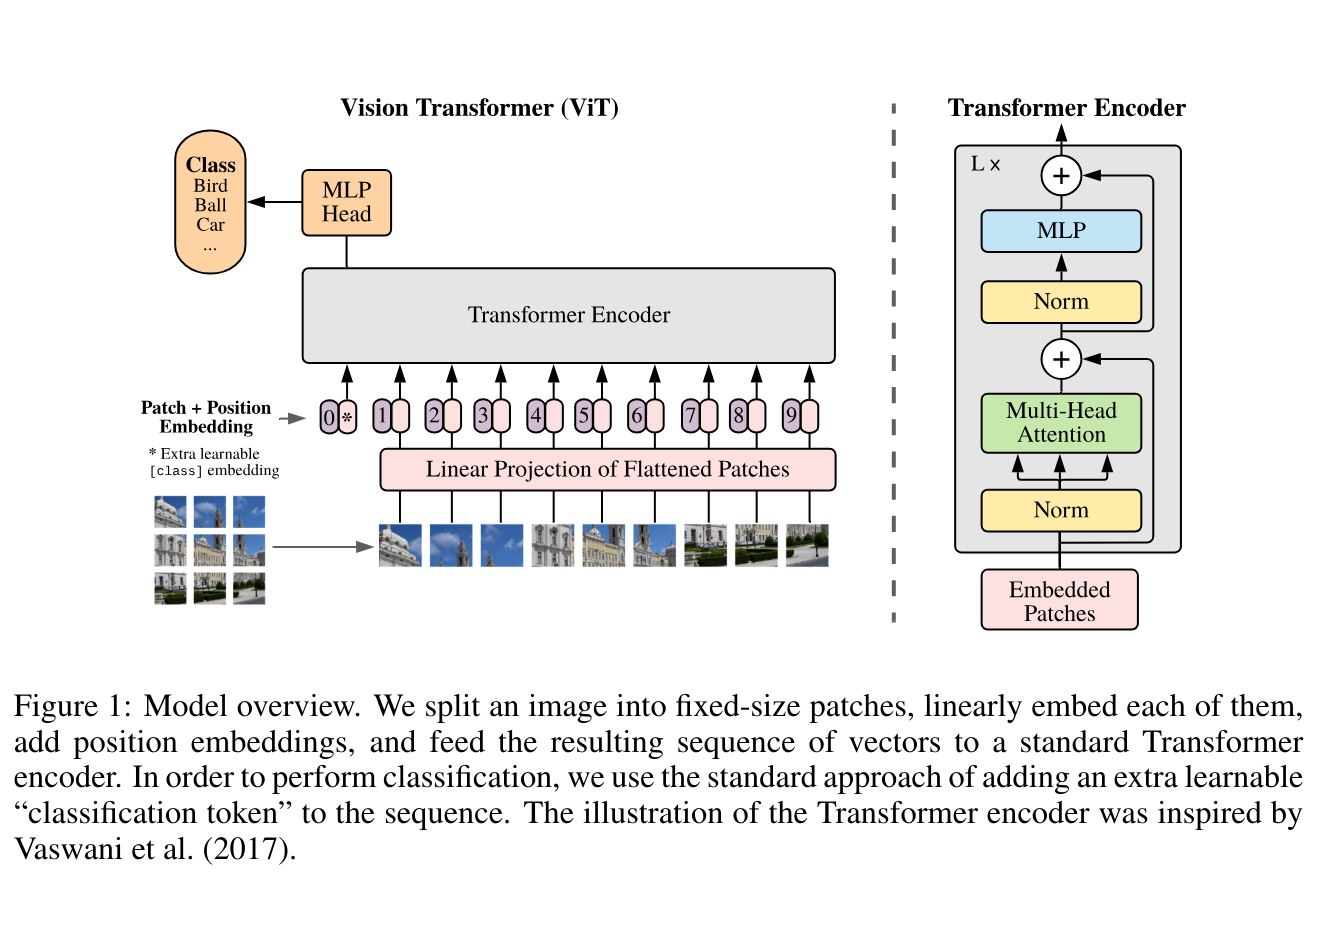

In [ ]:
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
from pathlib import Path

In [ ]:
data_paths = Path('/kaggle/input/updatedxray/data_split')
train_dir= data_paths / 'train'
valid_dir = data_paths / 'validation'
test_dir = data_paths / 'test'
BATCH_SIZE = 32

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int):

    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [ ]:
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [ ]:
train_dataloader, _, _ = create_dataloaders(train_dir=train_dir, test_dir= test_dir, batch_size=BATCH_SIZE,transform = transforms_train)
_, test_dataloader, _ = create_dataloaders(train_dir=train_dir, test_dir= test_dir, batch_size=BATCH_SIZE,transform = transforms_test)
_, valid_dataloader, classnames = create_dataloaders(train_dir=train_dir, test_dir= valid_dir, batch_size=BATCH_SIZE,transform = transforms_test)

In [ ]:
img, label = next(iter(train_dataloader))
img, label = img[0], label[0] 

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img.permute(1,2,0))

In [ ]:
EPOCHS = 10

## Helper Functions

In [ ]:
# this code is from github repe that I take from

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import seaborn as sns
def train_step(model: torch.nn.Module, 
               dataloader: DataLoader, 
               loss_fn: nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Dict[str, float]:
 
    model.train()
    train_loss, train_acc = 0, 0
    all_labels, all_preds = [], []
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
        all_labels.extend(y.cpu().numpy())
        all_preds.extend(y_pred_class.cpu().numpy())

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    train_precision = precision_score(all_labels, all_preds, average='weighted')
    train_recall = recall_score(all_labels, all_preds, average='weighted')
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return {
        "loss": train_loss,
        "accuracy": train_acc,
        "precision": train_precision,
        "recall": train_recall,
        "f1": train_f1
    }

def test_step(model: torch.nn.Module, 
              dataloader: DataLoader, 
              loss_fn: nn.Module,
              device: torch.device) -> Tuple[Dict[str, float], List[int], List[int]]:

    model.eval()
    test_loss, test_acc = 0, 0
    all_labels, all_preds = [], []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(test_pred_labels.cpu().numpy())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    test_precision = precision_score(all_labels, all_preds, average='weighted')
    test_recall = recall_score(all_labels, all_preds, average='weighted')
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return {
        "loss": test_loss,
        "accuracy": test_acc,
        "precision": test_precision,
        "recall": test_recall,
        "f1": test_f1
    }, all_labels, all_preds

def train(model: torch.nn.Module, 
          train_dataloader: DataLoader, 
          test_dataloader: DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {
        "train_loss": [],
        "train_acc": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1": [],
        "test_loss": [],
        "test_acc": [],
        "test_precision": [],
        "test_recall": [],
        "test_f1": []
    }
    
    model.to(device)

    final_all_labels = []
    final_all_preds = []

    for epoch in tqdm(range(epochs)):
        train_metrics = train_step(model=model,
                                   dataloader=train_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   device=device)
        test_metrics, all_labels, all_preds = test_step(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 device=device)
        
        if epoch == epochs - 1:
            final_all_labels = all_labels
            final_all_preds = all_preds

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_metrics['loss']:.4f} | "
          f"train_acc: {train_metrics['accuracy']:.4f} | "
          f"train_precision: {train_metrics['precision']:.4f} | "
          f"train_recall: {train_metrics['recall']:.4f} | "
          f"train_f1: {train_metrics['f1']:.4f} | "
          f"test_loss: {test_metrics['loss']:.4f} | "
          f"test_acc: {test_metrics['accuracy']:.4f} | "
          f"test_precision: {test_metrics['precision']:.4f} | "
          f"test_recall: {test_metrics['recall']:.4f} | "
          f"test_f1: {test_metrics['f1']:.4f}"
        )

        results["train_loss"].append(train_metrics['loss'])
        results["train_acc"].append(train_metrics['accuracy'])
        results["train_precision"].append(train_metrics['precision'])
        results["train_recall"].append(train_metrics['recall'])
        results["train_f1"].append(train_metrics['f1'])
        
        results["test_loss"].append(test_metrics['loss'])
        results["test_acc"].append(test_metrics['accuracy'])
        results["test_precision"].append(test_metrics['precision'])
        results["test_recall"].append(test_metrics['recall'])
        results["test_f1"].append(test_metrics['f1'])

    # Plot confusion matrix
    conf_matrix = confusion_matrix(final_all_labels, final_all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return results

from pathlib import Path
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

## ViT model Training

In [ ]:
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model = torchvision.models.vit_b_16(weights=weights).to('cuda')
loss_fn = nn.CrossEntropyLoss()
optimzer = torch.optim.Adam(params=model.parameters(), lr=0.001)
summary(model = model)
results = train(model, train_dataloader, test_dataloader, optimizer = optimzer, loss_fn=loss_fn, epochs=EPOCHS, device=device)

In [ ]:
results

In [ ]:
loss = results["train_loss"]
test_loss = results["test_loss"]

accuracy = results["train_acc"]
test_accuracy = results["test_acc"]

epochs = range(len(results["train_loss"]))

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="train_accuracy")
plt.plot(epochs, test_accuracy, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
save_model(model=model,
                 target_dir="models",
                 model_name="vitdlmodel.pth")